© 2025. Triad National Security, LLC. All rights reserved.
This program was produced under U.S. Government contract 89233218CNA000001 for Los Alamos National Laboratory (LANL), which is operated by Triad National Security, LLC for the U.S. Department of Energy/National Nuclear Security Administration. All rights in the program are reserved by Triad National Security, LLC, and the U.S. Department of Energy/National Nuclear Security Administration. The Government is granted for itself and others acting on its behalf a nonexclusive, paid-up, irrevocable worldwide license in this material to reproduce, prepare. derivative works, distribute copies to the public, perform publicly and display publicly, and to permit others to do so.


"""
Analytic solution for H.A. Lauweier "The transport of heat in an oil layer caused by the injection of hot fluid" (1955). Thermo-Hydro coupled solution

Injection of water at a constant rate into a single fracture in thermally active impermeable matrix. Fracture aperature is fixed.
"""

In [4]:
import numpy as np
import matplotlib.pylab as plt
from scipy.special import erfc
%matplotlib inline

In [5]:

def fracture_temperature(xi, theta, tau, T_inject, T0):
    """ Analytic solution for pressure

    Parameters
    -------------------
        xi : numpy array 
            dimensionless length
        theta : float
            ratio of specific heat of water and surrounding rock
        tau : float
            dimensionless time
        T_inject : float
            injection temperature
        T0 : float
            initial rock temperature

    Returns 
    -----------------
        temperature : numpy array
            temperature solution 

    Notes
    -----------------
        None
    
    """
    print("Computing Temperature (Lauwerier)")

    T_relative = (T_inject - T0)
    temperature = T_relative*erfc(xi/(2*np.sqrt(theta*(tau-xi)))) + T0

    return temperature

def matrix_temperature(xi, theta, tau, eta, T_inject, T0):
    """ Analytic solution for pressure

    Parameters
    -------------------
        xi : numpy array 
            dimensionless length
        theta : float
            ratio of specific heat of water and surrounding rock
        tau : float
            dimensionless time
        T_inject : float
            injection temperature
        T0 : float
            initial rock temperature

    Returns 
    -----------------
        temperature : numpy array
            temperature solution 

    Notes
    -----------------
        None
    
    """
    print("Computing Temperature (Lauwerier)")
    T_relative = (T_inject - T0)
    eta[(abs(eta)<1)] = 1 #constant temperature in fracture
    temperature = T_relative*erfc((xi+abs(eta)-1)/(2*np.sqrt(theta*(tau-xi)))) + T0
    return temperature

In [16]:

time = 250000 # s 

# Model Parameters 
rho_r = 2757 # density of rock (kg/m^3)
rho_w = 1000 # density of water (kg/m^3)

c_r = 1180 # heat capacity of rock (j/kg/K)
c_w = 4184 # heat capacity of water (j/kg/K)

b = 1e-3 # fracture aperature (m)

k_r = 0.5 # thermal conductivity rock (W/mK)
k_w = 0.598 # thermal conductivity water (W/mK)

v_w = 0.4025/100. # velocity of water in the fracture (m/s) 

Lx = 20 # domain length (m)
dx = 0.1  # spacing of grid points (m)
Nx = np.ceil(Lx / dx).astype(int)  # number of grid points
x_array = np.linspace(dx, Lx, Nx) # grid of points to compute solution

Lz = 20
dx = 0.1  # spacing of grid points (m)
Nx = np.ceil(Lz / dx).astype(int)  # number of grid points
z_array = np.linspace(-Lz/2, Lz/2, Nx) # grid of points to compute solution

xi = k_r/((b/2)**2*rho_w*c_w*v_w)*x_array # dimensionless distance along fracture

theta = rho_w*c_w/(rho_r*c_r) # ratio of specific heat of water and rock
eta = z_array/(b/2) #dimensionless distance perpendicular to fracture

T_inject = 90 # injection water temperature (degC)
T0 = 20 # initial rock temperature (degC)

tau = k_r/((b/2)**2*rho_w*c_w)*time # dimensionless time

fracture_temperature_analytic = fracture_temperature(xi,theta,tau,T_inject,T0)
matrix_temperature_analytic = matrix_temperature(xi, theta, tau, eta, T_inject, T0)

Computing Temperature (Lauwerier)
Computing Temperature (Lauwerier)


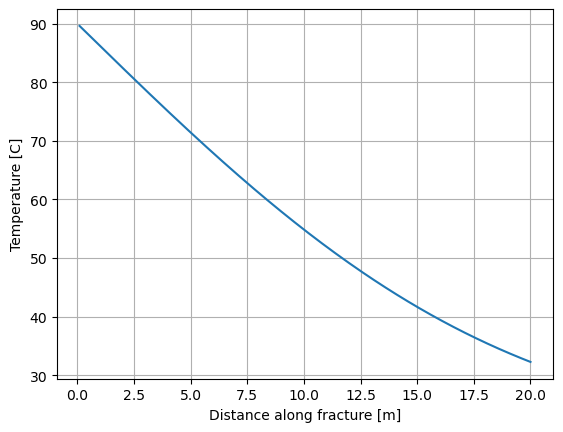

In [14]:
fig,ax = plt.subplots()
ax.plot(x_array, fracture_temperature_analytic)
plt.xlabel("Distance along fracture [m]")
plt.ylabel("Temperature [C]")
plt.grid(True)
plt.show() 

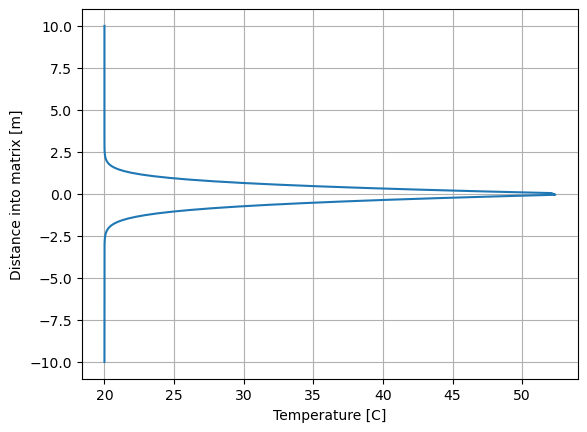

In [15]:
fig,ax = plt.subplots()
ax.plot(matrix_temperature_analytic, z_array)
plt.ylabel("Distance into matrix [m]")
plt.xlabel("Temperature [C]")
plt.grid(True)
plt.show() 
